## [KÜTÜPHANELERİN YÜKLENMESİ VE DOSYA YÜKLEME](#b2)

In [ ]:
import re
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Activation,Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten,GlobalMaxPooling1D,Conv1D, Embedding, LSTM

###### [Dosya yükleme](#b2)

In [ ]:
from google.colab import drive
import pandas as pd

# Google Drive'ı bağla
drive.mount('/content/drive')
%cd /content/drive/My Drive/Bitirme/Datasets/

# Veri setini yükle
#file_path = '/content/drive/My Drive/sentiment analysis/final_df.csv'
file_path = '/content/drive/My Drive/BitirmeMuammer/imdb/IMDB_Dataset.csv'
file_path2 = '/content/drive/My Drive/BitirmeMuammer/imdb/final_df_balanced.csv'
file_path3 = '/content/drive/My Drive/BitirmeMuammer/Proje/twitter_racism_parsed_dataset.csv'
file_path4 = '/content/drive/My Drive/BitirmeMuammer/USAir/final_df.csv'
file_path5 = '/content/drive/My Drive/Bitirme/Datasets/USAir_PreprocessedSon4_2output_df.csv'
file_path6 = '/content/drive/My Drive/Bitirme/Datasets/USAir_PreprocessedSon3_2output_df.csv'

df = pd.read_csv(file_path6, encoding='latin1', header=None)
#df = pd.read_csv(file_path4, index_col=0)

# Sütun isimlerini belirle
#df.columns = ['index', 'id','Text','label','score']
df.columns=['Text','tokens', 'text_length', 'hibrit', 'USAirPrePro', 'USAirPrePro2',
       'MuammerNLPPrePRro', 'MuammerNLPPrePRro2', 'MuammerNLPLSTMPrePRro',
       'score', 'oh_label']

# İlk sütunu kontrol edelim
print("Sütun isimleri:", df.columns)


MessageError: Error: credential propagation was unsuccessful

In [ ]:
"""# İsimsiz (NaN olarak görünen) sütunu kaldır
df = df.drop(columns=[df.columns[0]])"""

In [ ]:
# 'score' sütununu sayıya çevir (hatalı satırları düşürmek için errors='coerce' kullanıyoruz)
df['score'] = pd.to_numeric(df['score'], errors='coerce')

# 'score' sütunundaki NaN değerleri olan satırları silelim
df = df.dropna(subset=['score'])

# 'score' sütununu tam sayı yapalım
df['score'] = df['score'].astype(int)

# Güncellenmiş duygu skoru dağılımını kontrol edelim
print("Duygu skoru dağılımı (temizlendikten sonra):\n", df['score'].value_counts())

# Negatif, nötr ve pozitif sınıfları tekrar ayıralım
df_negatif = df[df['score'] == -1]
#df_notr = df[df['score'] == 0].sample(n=5000, random_state=42)  # 5000 satır örnekleme
df_pozitif = df[df['score'] == 1].sample(n=4741, random_state=42)  # 4741 satır örnekleme

# Yeni veri setini birleştir
df2 = pd.concat([df_negatif,  df_pozitif])

"""# Yeni veri setini kaydet
balanced_file_path = '/content/drive/My Drive/BitirmeMuammer/USAir/final_df_balanced.csv'
df_balanced.to_csv(balanced_file_path, index=False)"""

# Son durumu kontrol edelim
print("Duygu skoru dağılımı (son hali):\n", df2['score'].value_counts())
#print("İşlem tamamlandı. Yeni dosya kaydedildi:", balanced_file_path)


Duygu skoru dağılımı (temizlendikten sonra):
 score
 1    5000
-1    4741
Name: count, dtype: int64
Duygu skoru dağılımı (son hali):
 score
-1    4741
 1    4741
Name: count, dtype: int64


<ipython-input-4-00554c6e3407>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(int)


###### [Veri Setini inceleme](#b2)

In [ ]:
df

In [ ]:
df = df.drop(df.index[0])

In [ ]:
df=df2
df

,Text,tokens,text_length,hibrit,USAirPrePro,USAirPrePro2,MuammerNLPPrePRro,MuammerNLPPrePRro2,MuammerNLPLSTMPrePRro,score,oh_label
1,"At Wipro, growth remains a mirage","[""['Micro', 'growth', 'remain', 'murat']""]",33,wipro growth remains mirage,wipro growth remain mirag,wipro growth remains mirage,At Wipro growth remains mirage,"At Wipro, growth remains a mirage","wipro , growth remain mirag",-1,0
2,Why Chinese stocks leave US investors vulnerable,"[""['Chinese', 'stick', 'leave', 'of', 'investo...",48,chinese stocks leave us investors vulnerable,chines stock leav u investor vulner,chinese stock leave u investor vulnerable,Why Chinese stocks leave US investors vulnerable,Why Chinese stocks leave US investors vulnerable,chines stock leav us investor vulner,-1,0
3,US stocks finish mixed amid more tech selling,"[""['of', 'stick', 'finish', 'fix', 'maid', 'ea...",45,us stocks finish mixed amid tech selling,u stock finish mix amid tech sell,u stock finish mixed amid tech selling,US stocks finish mixed amid more tech selling,US stocks finish mixed amid more tech selling,us stock finish mix amid tech sell,-1,0
4,Opec reduces estimate on oil demand growth,"[""['OPEC', 'reduces', 'estimate', 'oil', 'dema...",42,opec reduces estimate oil demand growth,opec reduc estim oil demand growth,opec reduces estimate oil demand growth,Opec reduces estimate on oil demand growth,Opec reduces estimate on oil demand growth,opec reduc estim oil demand growth,-1,0
5,Immediate support for rupee is placed at 55.10...,"[""['immediate', 'support', 'rule', 'place', '5...",55,immediate support rupee placed bonanza,immedi support rupe place bonanza,immediate support rupee placed bonanza,Immediate support for rupee is placed at Bonanza,Immediate support for rupee is placed at 55.10...,immedi support rupe place bonanza,-1,0
...,...,...,...,...,...,...,...,...,...,...,...
5304,Satama 's net profit for the third quarter of ...,"[""['satsuma', 'ten', 'profit', 'third', 'quart...",148,satama net profit third quarter rose euro euro...,satama net profit third quarter rose euro euro...,satama net profit third quarter rose euro euro...,Satama net profit for the third quarter of ros...,Satama 's net profit for the third quarter of ...,"satama 's net profit third quarter rose , euro...",1,2
8178,Uflex Q2 Net up 19% to Rs 77.74 crore,"[""['flex', 'q', 'ten', '1', 'Is', '7774', 'cor...",37,uflex net rs crore,uflex q net r crore,uflex q net r crore,Uflex Net up to Rs crore,Uflex Q2 Net up 19% to Rs 77.74 crore,uflex q net rs crore,1,2
6435,RT @jenny_hegel: Find great deals on Sale Elec...,"[""['ceremony', 'fund', 'great', 'lead', 'last'...",151,rt jenny hegel find great deals sale electroni...,rt jennyhegel find great deal sale electron ko...,rt jennyhegel find great deal sale electronics...,RT jenny hegel Find great deals on Sale Electr...,RT @jenny_hegel: Find great deals on Sale Elec...,rt jennyhegel find great deal sale electron ko...,1,2
5787,"Post-correction, buyers return to gold stores","[""['post correction', 'bier', 'return', 'fold'...",45,post correction buyers return gold stores,postcorrect buyer return gold store,postcorrection buyer return gold store,Post correction buyers return to gold stores,"Post-correction, buyers return to gold stores","postcorrect , buyer return gold store",1,2


In [ ]:
df.head()

,Text,tokens,text_length,hibrit,USAirPrePro,USAirPrePro2,MuammerNLPPrePRro,MuammerNLPPrePRro2,MuammerNLPLSTMPrePRro,score,oh_label
1,"At Wipro, growth remains a mirage","[""['Micro', 'growth', 'remain', 'murat']""]",33,wipro growth remains mirage,wipro growth remain mirag,wipro growth remains mirage,At Wipro growth remains mirage,"At Wipro, growth remains a mirage","wipro , growth remain mirag",-1,0
2,Why Chinese stocks leave US investors vulnerable,"[""['Chinese', 'stick', 'leave', 'of', 'investo...",48,chinese stocks leave us investors vulnerable,chines stock leav u investor vulner,chinese stock leave u investor vulnerable,Why Chinese stocks leave US investors vulnerable,Why Chinese stocks leave US investors vulnerable,chines stock leav us investor vulner,-1,0
3,US stocks finish mixed amid more tech selling,"[""['of', 'stick', 'finish', 'fix', 'maid', 'ea...",45,us stocks finish mixed amid tech selling,u stock finish mix amid tech sell,u stock finish mixed amid tech selling,US stocks finish mixed amid more tech selling,US stocks finish mixed amid more tech selling,us stock finish mix amid tech sell,-1,0
4,Opec reduces estimate on oil demand growth,"[""['OPEC', 'reduces', 'estimate', 'oil', 'dema...",42,opec reduces estimate oil demand growth,opec reduc estim oil demand growth,opec reduces estimate oil demand growth,Opec reduces estimate on oil demand growth,Opec reduces estimate on oil demand growth,opec reduc estim oil demand growth,-1,0
5,Immediate support for rupee is placed at 55.10...,"[""['immediate', 'support', 'rule', 'place', '5...",55,immediate support rupee placed bonanza,immedi support rupe place bonanza,immediate support rupee placed bonanza,Immediate support for rupee is placed at Bonanza,Immediate support for rupee is placed at 55.10...,immedi support rupe place bonanza,-1,0


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [ ]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9741 entries, 1 to 9741
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Text                   9741 non-null   object
 1   tokens                 9741 non-null   object
 2   text_length            9741 non-null   object
 3   hibrit                 9741 non-null   object
 4   USAirPrePro            9741 non-null   object
 5   USAirPrePro2           9741 non-null   object
 6   MuammerNLPPrePRro      9741 non-null   object
 7   MuammerNLPPrePRro2     9741 non-null   object
 8   MuammerNLPLSTMPrePRro  9741 non-null   object
 9   score                  9741 non-null   object
 10  oh_label               9741 non-null   object
dtypes: object(11)
memory usage: 837.2+ KB


>Checking for null values:

In [ ]:
df.isnull().sum()

,0
Text,0
tokens,0
text_length,0
hibrit,0
USAirPrePro,0
USAirPrePro2,0
MuammerNLPPrePRro,0
MuammerNLPPrePRro2,0
MuammerNLPLSTMPrePRro,0
score,0


In [ ]:
df["sentiment"]=df['score']

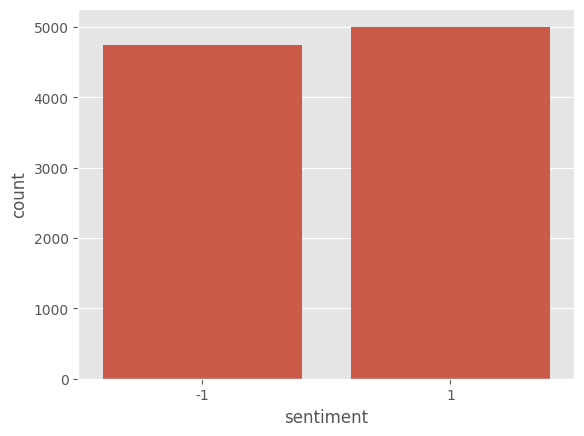

In [ ]:
import seaborn as sns
plt.style.use("ggplot")
sns.countplot(data = df, x = df["sentiment"])
plt.show()

In [ ]:
df["sentiment"].value_counts()

,count
sentiment,
1,5000
-1,4741


- So, there is no class imbalance both class has an equal number of data.

###### [Veri ön işleme](#b2)

In [ ]:
import re
import nltk
import spacy
from nltk.corpus import stopwords
import en_core_web_sm
# Gerekli kaynakları indir
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stopwords_list = set(stopwords.words('english'))


TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)


class CustomPreprocess():

    def __init__(self):
        pass

    def preprocess_text(self,sen):
        sen = sen.lower()

        # Remove html tags
        sentence = remove_tags(sen)

        # Remove punctuations and numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)

        # Single character removal
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

        # Remove multiple spaces
        sentence = re.sub(r'\s+', ' ', sentence)

        # Remove Stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)

        return sentence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
custom = CustomPreprocess()
custom.preprocess_text("I thought this was a wonderful way to spend time on a too hot summer weekend")

'thought wonderful way spend time hot summer weekend'

In [ ]:
x = []
sentences = list(df['review'])
for sen in sentences:
    x.append(custom.preprocess_text(sen))

In [ ]:
x = []
sentences = list(df['Text'])
for sen in sentences:
    x.append(custom.preprocess_text(sen))

In [ ]:
#x=df['Text']
x

['wipro growth remains mirage',
 'chinese stocks leave us investors vulnerable',
 'us stocks finish mixed amid tech selling',
 'opec reduces estimate oil demand growth',
 'immediate support rupee placed bonanza',
 'srei infra moving sideways ashwani gujral market strategist',
 'sweet sugar turns bitter mill owners ',
 'foreign investors navigate turmoil chinese markets new playbook',
 'nif may turn co plaintiff modern india suit nsel',
 'nif may turn co plaintiff modern india suit nsel',
 'stock buzz sun pharma may face resistance current levels',
 'investors wary cyclicals even narendra modi wins',
 'markets move sideways next upside starts ashwani gujral',
 'stock markets see cautious trading amid elections iip data report',
 'cautious amount stock buy beml devang visaria',
 'immediate resistance reliance around levels mileen vasudeo angel broking',
 ' sahara investors claim refund sebi',
 'greater yuan volatility boon china',
 'bond yields hit month high auction outcome eyed',
 'fpi

In [ ]:
df['score'] = pd.to_numeric(df['score'], errors='coerce')


In [ ]:
#Burda -1 olanlar 0 yapıldı 1 olanlar kaldı
df['score2'] = df['score'].apply(lambda x: x + 1 if x == -1 else x)

In [ ]:
y=df['score2']
y

,score2
1,0
2,0
3,0
4,0
5,0
...,...
9737,1
9738,1
9739,1
9740,1


In [ ]:
"""y = df['sentiment']
sentiment_map = {'negative' : 0, 'positive': 1}
y = np.array(y.map(sentiment_map))
y[:15]"""

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

###### [Train-Test Ayrımı](#b2)

In [ ]:
x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

###### [Tokenize ve embeding](#b2)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
vocab_length = len(tokenizer.word_index)+1
vocab_length

9814

In [ ]:
maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [ ]:
x_train

array([[5332, 1385,  180, ...,    0,    0,    0],
       [  59,  249,   41, ...,    0,    0,    0],
       [ 271,   25,   40, ...,    0,    0,    0],
       ...,
       [1073,  266, 5058, ...,    0,    0,    0],
       [  68, 1886,   23, ...,    0,    0,    0],
       [1680,  388, 3655, ...,    0,    0,    0]], dtype=int32)

In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')
"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# GloVe dosya yolu (Google Drive'daki konum)
glove_path = "/content/drive/My Drive/BitirmeMuammer/imdb/glove.6B.100d.txt"

# Embedding sözlüğünü oluşturma
embeddings_dictionary = dict()
with open(glove_path, encoding='utf8') as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions


In [ ]:
print(list(tokenizer.word_index.items())[:15])

[('eur', 1), ('net', 2), ('profit', 3), ('mn', 4), ('rs', 5), ('stocks', 6), ('year', 7), ('sales', 8), ('million', 9), ('quarter', 10), ('crore', 11), ('company', 12), ('finnish', 13), ('shares', 14), ('loss', 15)]


In [ ]:
embeddings_dictionary.get('Airlines')

In [ ]:
embedding_matrix = np.zeros((vocab_length, 100)) #100
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(9814, 100)

> Model Building:
>> Convenitonal Neural Network:

## [CNN](#b2)

In [ ]:
from keras.layers import Conv1D
cnn = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
cnn.add(embedding_layer)
cnn.add(Conv1D(128,5,activation = 'relu'))
cnn.add(Dropout(0.2))

cnn.add(Conv1D(256,5,activation = 'relu'))
cnn.add(GlobalMaxPooling1D())

cnn.add(Dense(1,activation = 'sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
cnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       981,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 981,400 (3.74 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 981,400 (3.74 MB)

In [ ]:
x_train

array([[5332, 1385,  180, ...,    0,    0,    0],
       [  59,  249,   41, ...,    0,    0,    0],
       [ 271,   25,   40, ...,    0,    0,    0],
       ...,
       [1073,  266, 5058, ...,    0,    0,    0],
       [  68, 1886,   23, ...,    0,    0,    0],
       [1680,  388, 3655, ...,    0,    0,    0]], dtype=int32)

In [ ]:
print(type(x_train), x_train.dtype)
print(type(y_train), y_train.dtype)


<class 'numpy.ndarray'> int32
<class 'pandas.core.series.Series'> int64


In [ ]:
import numpy as np

# Pandas Series'i NumPy array'e çevir ve uygun tipe dönüştür
y_train = y_train.to_numpy().astype('int32')  # veya float32, modele göre değişir
y_test = y_test.to_numpy().astype('int32')

In [ ]:
history_cnn = cnn.fit(x_train,y_train, batch_size=128, epochs = 100,
                      verbose=1, validation_split =0.2)

NameError: name 'cnn' is not defined

In [ ]:
cnn_result = cnn.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", cnn_result[1])
print("Test Loss:", cnn_result[0])

NameError: name 'cnn' is not defined

In [ ]:
from sklearn.metrics import classification_report
y_pred = cnn.predict(x_test)  # cnn_result değil!
y_pred_classes = np.argmax(y_pred, axis=1)
report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(report)


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       962
           1       0.00      0.00      0.00       987

    accuracy                           0.49      1949
   macro avg       0.25      0.50      0.33      1949
weighted avg       0.24      0.49      0.33      1949



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
history_cnn = cnn.fit(x_train,y_train, batch_size=128, epochs = 150,
                      verbose=1, validation_split =0.2)

Epoch 1/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 409ms/step - accuracy: 0.9943 - loss: 0.0123 - val_accuracy: 0.8454 - val_loss: 1.1543
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 386ms/step - accuracy: 0.9947 - loss: 0.0118 - val_accuracy: 0.8409 - val_loss: 1.0254
Epoch 3/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 451ms/step - accuracy: 0.9963 - loss: 0.0096 - val_accuracy: 0.8486 - val_loss: 1.0546
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - accuracy: 0.9969 - loss: 0.0068 - val_accuracy: 0.8409 - val_loss: 1.0998
Epoch 5/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 423ms/step - accuracy: 0.9955 - loss: 0.0111 - val_accuracy: 0.8467 - val_loss: 1.0361
Epoch 6/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 398ms/step - accuracy: 0.9962 - loss: 0.0092 - val_accuracy: 0.8428 - val_loss: 1.0453
Epoch 7/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step - accuracy: 0.9976 - loss: 0.0068 - val_accuracy: 0.8422 - val_loss: 1.1016
Epoch 8/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 386ms/step - accuracy: 0.9961 - loss: 0.0080 - 

In [ ]:
cnn_result = cnn.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", cnn_result[1])
print("Test Loss:", cnn_result[0])

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8289 - loss: 1.6498
Test Accuracy: 0.8286300897598267
Test Loss: 1.6130177974700928


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


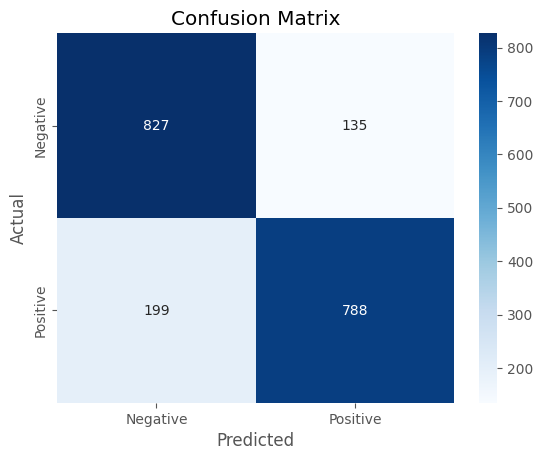

📌 Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.86      0.83       962
    Positive       0.85      0.80      0.83       987

    accuracy                           0.83      1949
   macro avg       0.83      0.83      0.83      1949
weighted avg       0.83      0.83      0.83      1949



In [ ]:
#2 Sınıf varsa
from sklearn.metrics import confusion_matrix
y_pred_prob = cnn.predict(x_test)                         # Olasılıklar (0-1 arası)
y_pred = (y_pred_prob >= 0.5).astype(int)                 # 0.5 eşik ile sınıf tahmini

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
from sklearn.metrics import classification_report
print("📌 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


ValueError: x and y must have same first dimension, but have shapes (10,) and (150,)

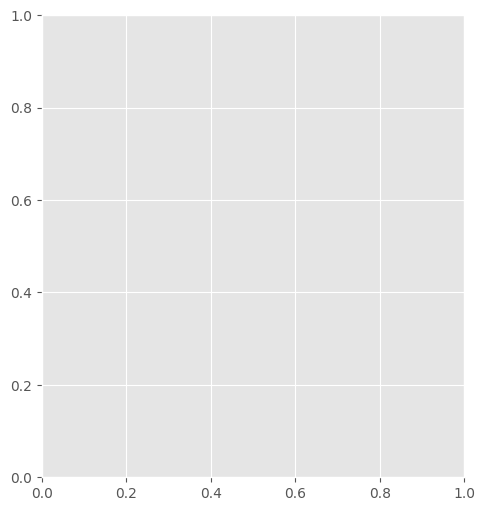

In [ ]:
plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history_cnn.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_cnn.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

## [LSTM](#b2)

In [ ]:
lstm = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
lstm.add(embedding_layer)
lstm.add(LSTM(256)) #return_sequences=True
# lstm.add(LSTM(128, return_sequences=True))

# lstm.add(Dropout(0.2))
# lstm.add(LSTM(64))


# cnn.add(Conv1D(512,5,activation = 'relu'))
# cnn.add(GlobalMaxPooling1D())

lstm.add(Dense(1,activation = 'sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
lstm.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,818,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,818,800 (6.94 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,818,800 (6.94 MB)

In [ ]:
history_lstm = lstm.fit(x_train,y_train, batch_size=128, epochs = 100,
                      verbose=1, validation_split =0.2)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 64s 901ms/step - accuracy: 0.8514 - loss: 0.4379 - val_accuracy: 0.8590 - val_loss: 0.2354
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 80s 873ms/step - accuracy: 0.8871 - loss: 0.2673 - val_accuracy: 0.8915 - val_loss: 0.2360
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 86s 936ms/step - accuracy: 0.8783 - loss: 0.2627 - val_accuracy: 0.9142 - val_loss: 0.2202
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 77s 863ms/step - accuracy: 0.8856 - loss: 0.2430 - val_accuracy: 0.8776 - val_loss: 0.2295
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 86s 924ms/step - accuracy: 0.8668 - loss: 0.2841 - val_accuracy: 0.8687 - val_loss: 0.3877
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 79s 883ms/step - accuracy: 0.8521 - loss: 0.4195 - val_accuracy: 0.8697 - val_loss: 0.3879
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 81s 870ms/step - accuracy: 0.8466 - loss: 0.4304 - val_accuracy: 0.8697 - val_loss: 0.3941
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 82s 873ms/step - accuracy: 0.8541 - loss: 0.4185 - 

In [ ]:
lstm_result = lstm.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", lstm_result[1])
print("Test Loss:", lstm_result[0])

85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.8600 - loss: 0.4059
Test Accuracy: 0.8515769839286804
Test Loss: 0.4202830493450165


In [ ]:
y_pred = lstm.predict(x_test)  # cnn_result değil!
y_pred_classes = np.argmax(y_pred, axis=1)
report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(report)


85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2295
           1       0.00      0.00      0.00       400

    accuracy                           0.85      2695
   macro avg       0.43      0.50      0.46      2695
weighted avg       0.73      0.85      0.78      2695



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: x and y must have same first dimension, but have shapes (10,) and (100,)

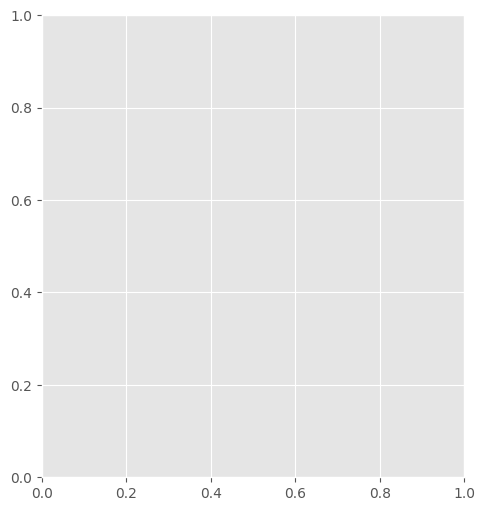

In [ ]:
plt.figure(figsize=(12,6))
epochs = range(1, 11)
plt.subplot(1,2,1)
plt.plot(epochs,history_lstm.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_lstm.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

In [ ]:
lstm.save("sentiment_classifier2.h5")

## [HİBRİT](#b2)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Model parametreleri
embedding_dim = 100
lstm_units = 512
dropout_rate = 0.5
activation_fn = 'tanh'
learning_rate = 0.002
batch_size = 256
epochs = 10

# Bi-LSTM modeli
model = Sequential()
model.add(Embedding(input_dim=vocab_length, output_dim=embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(units=lstm_units, activation=activation_fn, return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

# Derleme
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# Early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Eğitim
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 1404s 11s/step - accuracy: 0.6525 - loss: 0.6431 - val_accuracy: 0.8468 - val_loss: 0.5846
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1360s 11s/step - accuracy: 0.9333 - loss: 0.1759 - val_accuracy: 0.8591 - val_loss: 0.4502
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1394s 11s/step - accuracy: 0.9817 - loss: 0.0555 - val_accuracy: 0.8646 - val_loss: 0.3386
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1378s 11s/step - accuracy: 0.9924 - loss: 0.0233 - val_accuracy: 0.8515 - val_loss: 0.4123
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1415s 11s/step - accuracy: 0.9953 - loss: 0.0155 - val_accuracy: 0.8600 - val_loss: 0.7708
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1385s 11s/step - accuracy: 0.9950 - loss: 0.0167 - val_accuracy: 0.8478 - val_loss: 0.7298


In [ ]:
# Model özeti
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (256, 100, 100)        │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (256, 1024)            │     2,510,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (256, 1024)            │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (256, 1024)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (256, 1)               │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,262,013 (134.51 MB)

 Trainable params: 11,753,321 (44.84 MB)

 Non-trainable params: 2,048 (8.00 KB)

 Optimizer params: 23,506,644 (89.67 MB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 160s 510ms/step


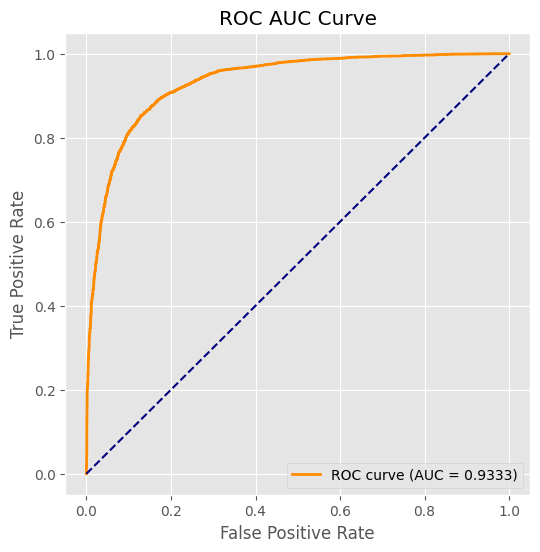

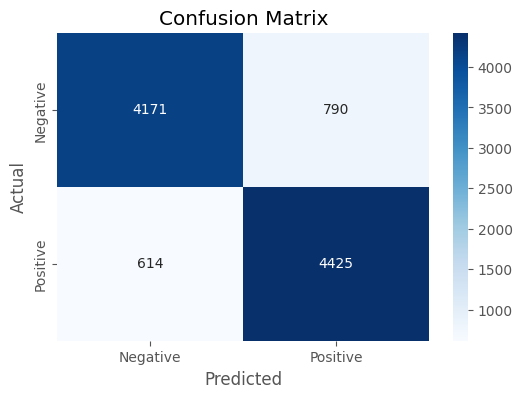

📌 Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.84      0.86      4961
    Positive       0.85      0.88      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



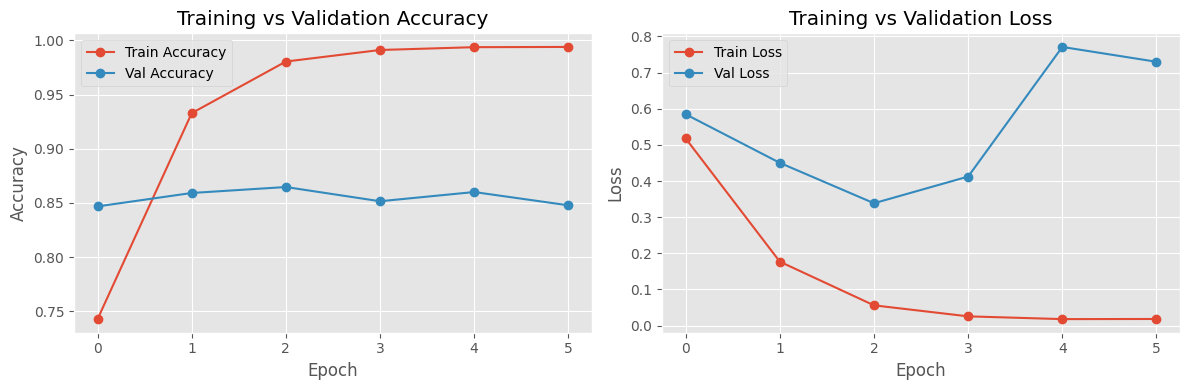

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Tahmin ve sınıflandırma ---
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

# --- 2. ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 3. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 4. Classification Report ---
print("📌 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# --- 5. Accuracy ve Loss Grafikleri ---
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


##[GNN](#b2)

In [ ]:
!pip install torch
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

class GNN_LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_classes):
        super(GNN_LSTM_Model, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # Freeze the embedding layer

        # Graph Convolutional Network layer
        self.gcn1 = GCNConv(embedding_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)

        # LSTM layer
        self.lstm = nn.LSTM(hidden_dim, 256)

        # Final dense layer for sentiment classification
        self.fc = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        # Apply embedding layer
        x = self.embedding(x)

        # Apply GCN layers
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = self.gcn2(x, edge_index)
        x = F.relu(x)

        # LSTM layer
        x, (hn, cn) = self.lstm(x)

        # Output layer
        x = self.fc(x[-1, :, :])

        return F.sigmoid(x)


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [ ]:
import torch
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Model, optimizer ve loss fonksiyonu
model = GNN_LSTM_Model(vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_classes)
criterion = nn.BCELoss() if num_classes == 1 else nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Eğitim geçmişi (history) sözlüğü
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# Eğitim döngüsü
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in train_loader:
        x, edge_index, labels = batch.text, batch.edge_index, batch.label
        optimizer.zero_grad()
        outputs = model(x, edge_index).squeeze()

        # Binary classification için
        loss = criterion(outputs, labels.float() if num_classes == 1 else labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.round(outputs) if num_classes == 1 else torch.argmax(outputs, dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(all_labels, all_preds)
    history['train_loss'].append(total_loss / len(train_loader))
    history['train_acc'].append(train_acc)

    # Opsiyonel: doğrulama
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            x, edge_index, labels = batch.text, batch.edge_index, batch.label
            outputs = model(x, edge_index).squeeze()
            loss = criterion(outputs, labels.float() if num_classes == 1 else labels)
            val_loss += loss.item()
            preds = torch.round(outputs) if num_classes == 1 else torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    history['val_loss'].append(val_loss / len(val_loader))
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {history['train_loss'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, Val Acc: {val_acc:.4f}")


NameError: name 'train_loader' is not defined

In [ ]:
import numpy as np

# Örnek değerler — kendi projenize göre düzenleyin
vocab_size = 10000                     # kelime sayısı (embedding tablosu için)
embedding_dim = 300                   # her kelimenin embedding boyutu
hidden_dim = 128                      # GCN/LSTM ara katman boyutu
num_classes = 1                       # Binary classification (1), çok sınıflıysa örn. 3

# Embedding matrix — rastgele örnek, senin hazır bir embedding'in varsa onunla değiştir
embedding_matrix = np.random.rand(vocab_size, embedding_dim).astype(np.float32)


In [ ]:
model = GNN_LSTM_Model(vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_classes)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Örnek: veriniz X (input indices), edge_index ve y (etiketler)
# Bunları PyTorch tensor'larına dönüştürmelisiniz:
X_tensor = torch.tensor(X_data, dtype=torch.long)
y_tensor = torch.tensor(y_data, dtype=torch.float if num_classes == 1 else torch.long)
edge_index_tensor = torch.tensor(edge_index_data, dtype=torch.long)

# edge_index her örnek için ayrıysa özel dataset oluşturmanız gerekebilir.
# Basit örnek için edge_index'i sabit sayalım:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, edge_index):
        self.X = X
        self.y = y
        self.edge_index = edge_index

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {
            'text': self.X[idx],
            'label': self.y[idx],
            'edge_index': self.edge_index
        }

dataset = GraphDataset(X_tensor, y_tensor, edge_index_tensor)


NameError: name 'X_data' is not defined

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
for batch in train_loader:
    x = batch['text']
    edge_index = batch['edge_index']
    labels = batch['label']
    ...


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


NameError: name 'history' is not defined

##[Simple RNN](#b2)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
import numpy as np

# Hyperparametrelerinizi tanımlayın (örnek değerler)
vocab_length = 10000          # kelime dağarcığınızın boyutu
embedding_dim = 100           # embedding boyutu
maxlen = 100                  # giriş dizilerinin uzunluğu
embedding_matrix = np.random.rand(vocab_length, embedding_dim)  # örnek embedding matrisi

# Modeli oluşturma
rnn = Sequential()

# Embedding katmanı (önceden eğitilmiş embedding matrisi ile)
embedding_layer = Embedding(
    input_dim=vocab_length,        # Kelime dağarcığı boyutu
    output_dim=embedding_dim,      # Embedding boyutu
    weights=[embedding_matrix],    # Öneceden eğitilmiş embedding matrisi
    input_length=maxlen,          # Giriş dizisinin uzunluğu
    trainable=False               # Embedding katmanını donmuş bırakıyoruz
)

rnn.add(embedding_layer)

# Simple RNN katmanı
rnn.add(SimpleRNN(128))  # 128 hücreli SimpleRNN katmanı

# Sonuç katmanı
rnn.add(Dense(1, activation='sigmoid'))  # Binary classification (duygu analizi)

# Derleme
rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model özeti
rnn.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
# Modeli eğitme
history = rnn.fit(
    x_train, y_train,         # Eğitim verisi ve etiketler
    epochs=50,                 # Eğitim epok sayısı
    batch_size=64,            # Her batch'teki örnek sayısı
    validation_data=(x_test, y_test),  # Doğrulama verisi
    verbose=1                 # Eğitim ilerlemesini görmek için
)


Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.5001 - loss: 0.6987 - val_accuracy: 0.5064 - val_loss: 0.6950
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.4959 - loss: 0.6966 - val_accuracy: 0.5064 - val_loss: 0.6931
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5117 - loss: 0.6947 - val_accuracy: 0.5064 - val_loss: 0.6932
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.4883 - loss: 0.6977 - val_accuracy: 0.4936 - val_loss: 0.6948
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.4957 - loss: 0.6951 - val_accuracy: 0.5064 - val_loss: 0.6950
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.5001 - loss: 0.6946 - val_accuracy: 0.4936 - val_loss: 0.6939
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.5040 - loss: 0.6954 - val_accuracy: 0.5064 - val_loss: 0.6932
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.5059 - loss: 0.6950 - val

In [ ]:
# Modeli eğitme
history = rnn.fit(
    x_train, y_train,         # Eğitim verisi ve etiketler
    epochs=150,                 # Eğitim epok sayısı
    batch_size=64,            # Her batch'teki örnek sayısı
    validation_data=(x_test, y_test),  # Doğrulama verisi
    verbose=1                 # Eğitim ilerlemesini görmek için
)

Epoch 1/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.5038 - loss: 0.6938 - val_accuracy: 0.5064 - val_loss: 0.6985
Epoch 2/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.5073 - loss: 0.6951 - val_accuracy: 0.4936 - val_loss: 0.6933
Epoch 3/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5027 - loss: 0.6938 - val_accuracy: 0.4936 - val_loss: 0.6938
Epoch 4/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5083 - loss: 0.6935 - val_accuracy: 0.5064 - val_loss: 0.6931
Epoch 5/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.5113 - loss: 0.6936 - val_accuracy: 0.5064 - val_loss: 0.6951
Epoch 6/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.4989 - loss: 0.6940 - val_accuracy: 0.5064 - val_loss: 0.6931
Epoch 7/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.5097 - loss: 0.6933 - val_accuracy: 0.5064 - val_loss: 0.6952
Epoch 8/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.5169 - loss: 0.693

In [ ]:
# Modeli eğitme
history = rnn.fit(
    x_train, y_train,         # Eğitim verisi ve etiketler
    epochs=150,                 # Eğitim epok sayısı
    batch_size=64,            # Her batch'teki örnek sayısı
    validation_data=(x_test, y_test),  # Doğrulama verisi
    verbose=1                 # Eğitim ilerlemesini görmek için
)

NameError: name 'rnn' is not defined

In [ ]:
#2 sınıf için
from sklearn.metrics import classification_report

# Olasılık tahminlerini al
y_pred_prob = rnn.predict(x_test)  # Sonuçlar 0-1 arası değerler

# 0.5 eşik değeri ile sınıf tahminine çevir
y_pred_classes = (y_pred_prob >= 0.5).astype(int)

# Classification report yazdır
report = classification_report(y_test, y_pred_classes, target_names=["Negative", "Positive"])
print("Classification Report:")
print(report)


NameError: name 'rnn' is not defined

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Modelden tahmin al
y_pred = rnn.predict(x_test)

# Sınıf indekslerine dönüştür
y_pred_classes = np.argmax(y_pred, axis=1)

# Eğer y_test one-hot ise önce class index'e dönüştürün
if y_test.ndim > 1:
    y_test_classes = np.argmax(y_test, axis=1)
else:
    y_test_classes = y_test

# Sınıflandırma raporunu yazdır
report = classification_report(y_test_classes, y_pred_classes)
print("Classification Report:")
print(report)


NameError: name 'rnn' is not defined

In [ ]:
#çoklu sınıf için
from sklearn.metrics import classification_report
y_pred = rnn.predict(x_test)  # cnn_result değil!
y_pred_classes = np.argmax(y_pred, axis=1)
report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(report)

NameError: name 'rnn' is not defined

In [ ]:
#çoklu Sınıf varsa kullanılacak confission matris
from sklearn.metrics import classification_report
y_pred = cnn.predict(x_test)  # cnn_result değil!
y_pred_classes = np.argmax(y_pred, axis=1)
report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(report)

In [ ]:
#2 Sınıf varsa
from sklearn.metrics import confusion_matrix
y_pred_prob = cnn.predict(x_test)                         # Olasılıklar (0-1 arası)
y_pred = (y_pred_prob >= 0.5).astype(int)                 # 0.5 eşik ile sınıf tahmini

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
from sklearn.metrics import classification_report
print("📌 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


## GRU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

model = Sequential()

# Embedding katmanı
model.add(Embedding(
    input_dim=vocab_length,
    output_dim=100,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=False
))

# GRU katmanı
model.add(GRU(128))

# Çıkış katmanıa
model.add(Dense(1, activation='sigmoid'))

# Modeli derle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


NameError: name 'vocab_length' is not defined

##Kaydetme-Tekrar yükleme ve notlar

In [ ]:
lstm.save("sentiment_classifier2.h5")
"""komutu, Keras/TensorFlow modelinizi HDF5 (H5) formatında diske kaydeder. Bu, modelin:
Mimarisini
Ağırlıklarını
Eğitim durumunu (optimizer, loss, metrikler)
bir dosyada saklar."""

In [ ]:
import os
print(os.getcwd())
"""Bu kod, .h5 dosyasının nereye kaydedildiğini görmenizi sağlar (çalışma dizinini verir)."""

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Kaydetme
lstm.save('/content/drive/MyDrive/sentiment_classifier2.h5')


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("sentiment_classifier2.h5")
"""Kaydedilen modeli daha sonra bu şekilde yükleyebilirsiniz:"""

In [ ]:
#1. Google Drive'ı Bağla
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#2. Modeli Drive’a Kaydet
# Modeli belirli bir klasöre kaydet (örneğin MyDrive altına)
lstm.save('/content/drive/MyDrive/sentiment_classifier2.h5')
#Modeli yeniden eğittikten sonra tekrar .save() ile üzerine yazabilirsin.


In [ ]:
#3. Daha Sonra Drive'dan Yükle
from tensorflow.keras.models import load_model

# Modeli Drive'dan yükle
model = load_model('/content/drive/MyDrive/sentiment_classifier2.h5')

# Artık model ile tahmin yapabilirsin
# örnek: model.predict(x_test)
